# Summary

Create `elaspic_standalone_core` and `elaspic_training_interface` databases and fill them with training data.

----

# Imports

In [1]:
%run imports.ipynb

2016-08-27 20:27:48.638462


In [2]:
%run db.ipynb

MySQL database already running...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-08-27 20:27:48.784160


In [3]:
NOTEBOOK_NAME = 'elaspic_standalone'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

In [4]:
# Start a database connection
db_local = datapkg.MySQLConnection(
    connection_string=db_daemon.get_connection_string(NOTEBOOK_NAME),
    shared_folder=os.environ['DB_TEMPDIR'],
    storage_host=None,
    datadir=db_daemon.datadir,
    echo=False,
    db_engine='MyISAM',
)

In [5]:
PDB_DIR = '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb'
# BLAST_DB_DIR = '/home/kimlab1/database_data/blast/db'
BLAST_DB_DIR = '/home/strokach/databases/blast/db'
ARCHIVE_DIR = '/home/kimlab1/database_data/elaspic_v2'

# Load data

In [660]:
CORE_DATASETS = [
    'protherm', 'protherm_star',
]
    
INTERFACE_DATASETS = [
    # No partner uniprot provided:
    'ab_bind', 'benedix_et_al', 'hiv_escape_mutations',
    #
    'kortemme_baker', 'skempi',
]

assert not (set(CORE_DATASETS) & set(INTERFACE_DATASETS))

In [661]:
DATA = {}

for dataset in CORE_DATASETS:
    DATA[dataset] = pd.read_sql_table(dataset, db.engine, schema='protein_folding_energy')

for dataset in INTERFACE_DATASETS:
    DATA[dataset] = pd.read_sql_table(dataset, db.engine, schema='protein_interaction_energy')

In [662]:
display(DATA['protherm_star'].head())
print(DATA['protherm_star'].shape[0])

,idx,RecordID,PDBFileID,Mutations,DDG,ResidueExposures,DSSPTypes,DSSPSimpleTypes,IndividualDDGs,pdb_id,pdb_chain,pdb_mutation,ddg_exp,uniprot_id,uniprot_mutation,pfam_id,pdb_chain_sifts,pdb_mutation_sifts,dataset
0,1,69,1A2P,A Q 104 A,0.09,0.671957671958,S,O,0.16_0.02,1a2p,A,A_Q104A,0.09,P00648,Q151A,PF00545,A,Q104A,alascan_gpk
1,2,68,1A2P,A I 109 A,1.63,0.214285714286,,O,1.27_2.22_1.4,1a2p,A,A_I109A,1.63,P00648,I156A,None,A,I109A,alascan_gpk
2,3,80,1A2P,A V 10 A,3.47,0,H,H,3.47,1a2p,A,A_V10A,3.47,P00648,V57A,None,A,V10A,alascan_gpk
3,4,71,1A2P,A R 110 A,-0.07,0.315352697095,,O,-0.07,1a2p,A,A_R110A,-0.07,P00648,R157A,None,A,R110A,alascan_gpk
4,5,83,1A2P,A D 12 A,0.39,0.529801324503,H,H,0.39,1a2p,A,A_D12A,0.39,P00648,D59A,None,A,D12A,alascan_gpk


8098


# RUN

In [1057]:
DATASET = 'skempi'
SUFFIX = '_2'

dataset_map = {
    'protherm_star': 'protherm'
}
JOB_NAME = (dataset_map.get(DATASET, DATASET) + SUFFIX)

In [1058]:
print(DATASET)
print(SUFFIX)
print(JOB_NAME)

skempi
_2
skempi_2


In [1059]:
DF = DATA[DATASET].copy()

In [1060]:
# Remove multi-mutants (for now)
_before = DF.shape[0]
DF = DF[~DF['pdb_mutation'].str.contains('\.')]
DF = DF[~DF['pdb_mutation'].str.contains(',')]
print("Lost {} multi-mutant rows.".format(_before - DF.shape[0]))

Lost 463 multi-mutant rows.


In [1061]:
if not DF['pdb_mutation'].str.contains('_').all():
    print("Adding 'pdb_chain' to 'pdb_mutation'")
    DF['pdb_mutation'] = DF['pdb_chain'] + '_' + DF['pdb_mutation']

Adding 'pdb_chain' to 'pdb_mutation'


In [1062]:
print(DF.shape[0])

1750


In [1063]:
DF['pdb_file'] = PDB_DIR + ('/pdb' + DF['pdb_id'] + '.ent.gz')

In [1064]:
DF.shape

(1750, 12)

In [1065]:
RUN_STAGE = 2  # 1: Provean and homology models, 2: Mutations
print("Run stage: {}".format(RUN_STAGE))

try:
    del DF_TO_CALCULATE, SYSTEM_COMMAND_TEMPLATE
except NameError:
    pass

Run stage: 2


In [1066]:
if RUN_STAGE == 1:
    DF_TO_CALCULATE = DF.drop_duplicates('pdb_file')
    print("Analysing {} unique proteins...".format(len(DF_TO_CALCULATE)))

    SYSTEM_COMMAND_TEMPLATE = """\
mkdir -p '{tempdir}' && \
cd '{tempdir}' && \
elaspic run -p '{pdb_file}' -t 'sequence.model' -vvv \
    --pdb_dir='%s/' \
    --blast_db_dir='%s' \
    --archive_dir='%s/' \
    # Decoys: {mutation} 
""" % (PDB_DIR, BLAST_DB_DIR, ARCHIVE_DIR)

In [1067]:
if RUN_STAGE == 2:
    DF_TO_CALCULATE = DF.drop_duplicates(['pdb_file', 'pdb_mutation'])
    print("Analysing {} unique mutations...".format(len(DF_TO_CALCULATE)))

    # NB: `-n` is "mutation_format"
    SYSTEM_COMMAND_TEMPLATE = """\
mkdir -p '{tempdir}' && \
cd '{tempdir}' && \
elaspic run -p '{pdb_file}' -t 'mutation' -m '{mutation}' -n 1 -vvv \
    --pdb_dir='%s/' \
    --blast_db_dir='%s' \
    --archive_dir='%s/'
""" % (PDB_DIR, BLAST_DB_DIR, ARCHIVE_DIR)

Analysing 1750 unique mutations...


In [1068]:
display(DF_TO_CALCULATE.head())
print(DF_TO_CALCULATE.shape[0])

,id,uniprot_id,partner_uniprot_id,uniprot_mutation,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,pfam_id,pfam_clan,ddg_exp,pdb_file
0,1,A0NA69,P01820,D71A,1dvf,D,B,D_D52A,None,None,1.682290,/home/kimlab1/database_data/pdb/data/data/stru...
1,2,A0NA69,P01820,K49A,1dvf,D,B,D_K30A,None,None,1.003517,/home/kimlab1/database_data/pdb/data/data/stru...
2,3,A0NA69,P01820,N74A,1dvf,D,B,D_N54A,None,None,1.860601,/home/kimlab1/database_data/pdb/data/data/stru...
3,4,P00044,P00431,A87G,2pcc,B,A,B_A81G,PF00034,CL0318,1.901004,/home/kimlab1/database_data/pdb/data/data/stru...
4,5,P00044,P00431,K78A,2pcc,B,A,B_K72A,PF00034,CL0318,0.303533,/home/kimlab1/database_data/pdb/data/data/stru...


1750


In [1069]:
DF_TO_CALCULATE['system_command'] = (
    DF_TO_CALCULATE.apply(
        lambda x: SYSTEM_COMMAND_TEMPLATE.format(
            tempdir=op.abspath(op.join(NOTEBOOK_NAME, JOB_NAME, x['pdb_id'].lower())),
            pdb_file=x['pdb_file'],
            mutation=x['pdb_mutation']),
        axis=1)
)

In [1070]:
display(DF_TO_CALCULATE.head())
print(DF_TO_CALCULATE.shape[0])

,id,uniprot_id,partner_uniprot_id,uniprot_mutation,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,pfam_id,pfam_clan,ddg_exp,pdb_file,system_command
0,1,A0NA69,P01820,D71A,1dvf,D,B,D_D52A,None,None,1.682290,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...
1,2,A0NA69,P01820,K49A,1dvf,D,B,D_K30A,None,None,1.003517,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...
2,3,A0NA69,P01820,N74A,1dvf,D,B,D_N54A,None,None,1.860601,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...
3,4,P00044,P00431,A87G,2pcc,B,A,B_A81G,PF00034,CL0318,1.901004,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...
4,5,P00044,P00431,K78A,2pcc,B,A,B_K72A,PF00034,CL0318,0.303533,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...


1750


In [1071]:
DF_TO_CALCULATE.loc[0, 'system_command']

"mkdir -p '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone/skempi_2/1dvf' && cd '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone/skempi_2/1dvf' && elaspic run -p '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/pdb1dvf.ent.gz' -t 'mutation' -m 'D_D52A' -n 1 -vvv     --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/'     --blast_db_dir='/home/strokach/databases/blast/db'     --archive_dir='/home/kimlab1/database_data/elaspic_v2/'\n"

## QSUB

In [1072]:
PATH = (
    '/home/kimlab1/strokach/anaconda/bin:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin'
)

In [1073]:
js = jobsubmitter.JobSubmitter(
    JOB_NAME, 
    'sge://:@192.168.6.201', 
    op.abspath(NOTEBOOK_NAME),
    force_new_folder=False,
    email='ostrokach@gmail.com', 
    nproc=1, queue='medium', walltime='8:00:00', mem='6G',
    env={'PATH': PATH},
)

Using an existing folder for log output. This is dangerous!!!


In [1074]:
js.job_name

'skempi_2'

In [1075]:
DF_TO_CALCULATE[['pdb_id', 'system_command']].values.tolist()[:1]

[['1dvf',
  "mkdir -p '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone/skempi_2/1dvf' && cd '/home/kimlab1/database_data/biodb/recipes/elaspic_training_set/notebooks/elaspic_standalone/skempi_2/1dvf' && elaspic run -p '/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/pdb1dvf.ent.gz' -t 'mutation' -m 'D_D52A' -n 1 -vvv     --pdb_dir='/home/kimlab1/database_data/pdb/data/data/structures/all/pdb/'     --blast_db_dir='/home/strokach/databases/blast/db'     --archive_dir='/home/kimlab1/database_data/elaspic_v2/'\n"]]

## Resubmit failed

In [1076]:
RUN_STAGE

2

In [1077]:
str(None)

'None'

In [1078]:
# Get job status
if RUN_STAGE == 1:
    results_df = js.job_status(DF_TO_CALCULATE[['pdb_id', 'system_command']].values.tolist())
elif RUN_STAGE == 2:
    results_df = js.job_status(DF_TO_CALCULATE.reset_index()[['index', 'system_command']].values.tolist())

print(Counter(results_df['status']))

Counter({'misformed output': 1733, 'frozen': 16, 'error': 1})


In [1079]:
results_df.tail()

,job_id,status,system_command
1745,2208,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
1746,2209,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
1747,2210,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
1748,2211,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...
1749,2212,misformed output,mkdir -p '/home/kimlab1/database_data/biodb/re...


In [1080]:
system_commands_remaining = results_df[results_df['status'].isin(['error', 'missing'])]

In [1081]:
system_commands_remaining.head()

,job_id,status,system_command
602,667,error,mkdir -p '/home/kimlab1/database_data/biodb/re...


In [1082]:
with js.connect():
    js.submit(system_commands_remaining[['job_id', 'system_command']].values.tolist())

# Results

## Read results

In [1083]:
ls $NOTEBOOK_NAME/$JOB_NAME/1ak4/.elaspic

1AK4ABCD.pdb  1AK4D.fasta            mutation_D_H487Q.json
1AK4AD.pdb    1AK4D.pdb              mutation_D_H487R.json
1AK4A.fasta   model/                 mutation_D_I491A.json
1AK4A.pdb     model.json             mutation_D_I491V.json
1AK4BC.pdb    mutation_D_A488G.json  mutation_D_P485A.json
1AK4BD.pdb    mutation_D_A488V.json  mutation_D_P490A.json
1AK4B.fasta   mutation_D_A492G.json  mutation_D_P493A.json
1AK4B.pdb     mutation_D_A492V.json  mutation_D_V486A.json
1AK4CD.pdb    mutation_D_G489A.json  sequence/
1AK4C.fasta   mutation_D_G489V.json  sequence.json
1AK4C.pdb     mutation_D_H487A.json


In [1085]:
def load_json(file):
    try:
        ifh = open(file, 'rt')
    except FileNotFoundError:
        data = np.nan
    else:
        data = json.load(ifh)
        ifh.close()
    return data

        
DF_TO_CALCULATE['mutation_json'] = (
    DF_TO_CALCULATE[['pdb_id', 'pdb_mutation']].apply(
        lambda x: load_json(
            op.join(
                NOTEBOOK_NAME,
                JOB_NAME,
                x[0].lower(),
                '.elaspic',
                'mutation_{}.json'.format(x[1]))), 
        axis=1)
)

In [1086]:
display(DF_TO_CALCULATE.head())
print(DF_TO_CALCULATE.shape[0])
print(DF_TO_CALCULATE['mutation_json'].isnull().sum())

,id,uniprot_id,partner_uniprot_id,uniprot_mutation,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,pfam_id,pfam_clan,ddg_exp,pdb_file,system_command,mutation_json
0,1,A0NA69,P01820,D71A,1dvf,D,B,D_D52A,None,None,1.682290,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'stability_energy_mut': '15.1283,-73.6586,-3..."
1,2,A0NA69,P01820,K49A,1dvf,D,B,D_K30A,None,None,1.003517,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,[{'solvent_accessibility_mut': 37.410375173691...
2,3,A0NA69,P01820,N74A,1dvf,D,B,D_N54A,None,None,1.860601,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,[{'solvent_accessibility_mut': 68.039184807781...
3,4,P00044,P00431,A87G,2pcc,B,A,B_A81G,PF00034,CL0318,1.901004,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,[{'solvent_accessibility_mut': 104.54294631710...
4,5,P00044,P00431,K78A,2pcc,B,A,B_K72A,PF00034,CL0318,0.303533,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'stability_energy_mut': '46.639,-66.5641,-36..."


1750
17


In [1087]:
DF_TO_CALCULATE.shape[0]

1750

## PDB chain mapping

In [1088]:
tempdir = tempfile.mkdtemp()

In [1089]:
print(tempdir)

/tmp/strokach/tmpdwvezva7


In [1090]:
for (pdb_id, pdb_file) in DF_TO_CALCULATE[['pdb_id', 'pdb_file']].drop_duplicates().values:
    with gzip.open(pdb_file) as ifh:
        with open(op.join(tempdir, '{}.pdb'.format(pdb_id)), 'wb') as ofh:
            ofh.write(ifh.read())

In [1091]:
sps = {}
for (pdb_id, pdb_file) in DF_TO_CALCULATE[['pdb_id', 'pdb_file']].drop_duplicates().values:
    sp = elaspic.structure_tools.StructureParser(op.join(tempdir, pdb_id + '.pdb'))
    sp.extract()
    sps[pdb_id] = sp

In [1092]:
pdb_idx2chain = {}
pdb_chain2idx = {}
for pdb_id, sp in sps.items():
    pdb_idx2chain[pdb_id] = {i: chain_id for i, chain_id in enumerate(sp.chain_ids)}
    pdb_chain2idx[pdb_id] = {chain_id: i for i, chain_id in enumerate(sp.chain_ids)}

## Core mutation features

## Interface mutation features

In [1093]:
DF_TO_CALCULATE.head(2)

,id,uniprot_id,partner_uniprot_id,uniprot_mutation,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,pfam_id,pfam_clan,ddg_exp,pdb_file,system_command,mutation_json
0,1,A0NA69,P01820,D71A,1dvf,D,B,D_D52A,None,None,1.682290,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,"[{'stability_energy_mut': '15.1283,-73.6586,-3..."
1,2,A0NA69,P01820,K49A,1dvf,D,B,D_K30A,None,None,1.003517,/home/kimlab1/database_data/pdb/data/data/stru...,mkdir -p '/home/kimlab1/database_data/biodb/re...,[{'solvent_accessibility_mut': 37.410375173691...


In [1094]:
imf = local.InterfaceMutationFeatures()

interface_mutation_features = [
    imf.guess(index, mutation_json)
    for index, mutation_json 
    in DF_TO_CALCULATE.reset_index()[['index', 'mutation_json']].dropna().values
]

interface_mutation_features_df = pd.concat(interface_mutation_features)

print(imf._num_mutations_not_in_interface)
print(imf._num_mutations_interface_not_found)

247
0


In [1095]:
interface_mutation_features_df.head(2)

,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,idx,idxs,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation,mutation_errors,mutation_modeller,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt
0,1.0,1.0,1.0,"30.8915,31.2845,-9.05228,-2.71061,-4.99341,-9....","31.6389,31.2845,-8.20853,-2.73506,-5.03042,-9....",D,5.218265,3.039727,1.404040,3,"[1, 3]",981.985,207.640,1189.625,-2,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,D52A,,D168A,-0.946689,"0,0,0,0","0,0,0,25","1,0,0,2","0,0,0,28",-4.954,E,E,6.337008,13.730679,"57.1569,-144.483,-65.0887,-267.752,-9.88724,36...","52.3012,-145.192,-65.7896,-268.612,-11.0386,36..."
0,1.0,1.0,1.0,"23.9019,32.3823,2.00765,-1.20792e-13,-1.263,-0...","24.6453,32.3823,2.05719,-7.81597e-14,-1.263,-0...",D,7.068026,6.144239,0.446862,3,"[0, 3]",401.885,30.975,432.855,-2,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,D52A,,D159A,-0.576504,"0,0,0,0","0,0,0,27","0,0,0,0","0,0,0,30",-4.954,E,E,6.372395,13.491773,"62.5577,-135.887,-64.9962,-247.139,-4.24786,33...","56.934,-136.552,-65.669,-247.895,-5.36963,339...."


In [1096]:
interface_mutation_features_df_final = (
    interface_mutation_features_df
    .merge(
        DF_TO_CALCULATE[
            ['pdb_id', 'pdb_chain', 'partner_pdb_chain', 'pdb_mutation', 'ddg_exp',
             'uniprot_id', 'partner_uniprot_id', 'uniprot_mutation', 'pfam_clan']], 
        left_index=True, right_index=True)
)

# DF_TO_CALCULATE
print2("Starting number of mutations:",
       DF_TO_CALCULATE.shape[0])
print2("Starting number of mutation indexes:",
       DF_TO_CALCULATE.index.drop_duplicates().shape[0])
print2("Number of unique pdb id / mutations:",
       DF_TO_CALCULATE[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])
print('-' * 80)

# results_df
print2("Number of ELASPIC PDB mutations:", 
       interface_mutation_features_df.shape[0])
print2("Number of ELASPIC PDB mutation indexes:",
       len(set(interface_mutation_features_df.index)))
print2("Number of unique ELASPIC pdb id / mutations:",
       interface_mutation_features_df[['idx', 'mutation']].drop_duplicates().shape[0])
print('-' * 80)

# interface_mutation_features_df_final
print2("Number of ELASPIC PDB mutations wddg_exp:", 
       interface_mutation_features_df_final.shape[0])
print2("Number of ELASPIC PDB mutation indexes wddg_exp:",
       len(set(interface_mutation_features_df_final.index)))
print2("Number of unique ELASPIC pdb id / mutations wddg_exp:",
       interface_mutation_features_df_final[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])

Starting number of mutations:                               1750
Starting number of mutation indexes:                        1750
Number of unique pdb id / mutations:                        1750
--------------------------------------------------------------------------------
Number of ELASPIC PDB mutations:                            1747
Number of ELASPIC PDB mutation indexes:                     1486
Number of unique ELASPIC pdb id / mutations:                1443
--------------------------------------------------------------------------------
Number of ELASPIC PDB mutations wddg_exp:                   1747
Number of ELASPIC PDB mutation indexes wddg_exp:            1486
Number of unique ELASPIC pdb id / mutations wddg_exp:       1486


## Correct duplicate interfaces

In [1097]:
interface_mutation_features_df_final = (
    interface_mutation_features_df_final.sort_values('contact_distance_wt', ascending=True))
interface_mutation_features_df_final.tail(2)

,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,idx,idxs,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation,mutation_errors,mutation_modeller,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,ddg_exp,uniprot_id,partner_uniprot_id,uniprot_mutation,pfam_clan
534,1.0,1.0,1.0,"75.1199,48.8328,-19.8905,-3.39935,-11.5601,-23...","75.7446,48.8328,-20.0603,-3.39935,-11.5601,-23...",B,8.122700,8.122700,0.249816,1,"[0, 1]",985.685,417.22,1402.905,-2,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,R29A,,R209A,-0.812414,"0,0,0,0","0,0,0,29","0,0,0,0","0,0,2,42",-2.670,E,E,7.390366,17.628204,"98.3888,-224.059,-121.393,-458.606,-18.8957,60...","99.0473,-224.18,-121.568,-459.919,-18.5879,608...",1a22,B,A,B_R270A,0.553860,P10912,P01241,R88A,CL0159
489,1.0,1.0,1.0,"75.7424,48.8328,-19.0557,-3.39935,-11.5601,-23...","75.8673,48.8328,-19.5137,-3.39935,-11.5601,-23...",B,8.721909,8.270372,0.028912,1,"[0, 1]",985.685,417.22,1402.905,-1,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,E128A,,E308A,-0.812414,"0,0,0,0","0,0,0,28","0,0,0,0","0,1,0,39",-3.767,E,E,8.367300,8.946996,"97.0995,-224.742,-122.986,-459.302,-15.5554,60...","98.0731,-224.833,-122.488,-460.516,-19.2105,60...",1a22,B,A,B_E373A,0.082765,P10912,P01241,E191A,CL0159


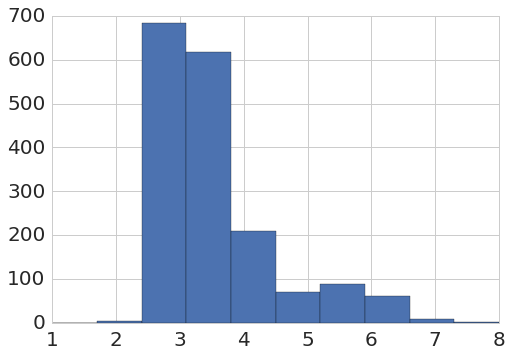

In [1098]:
interface_mutation_features_df_final['contact_distance_wt'].hist(range=(1, 8.0))

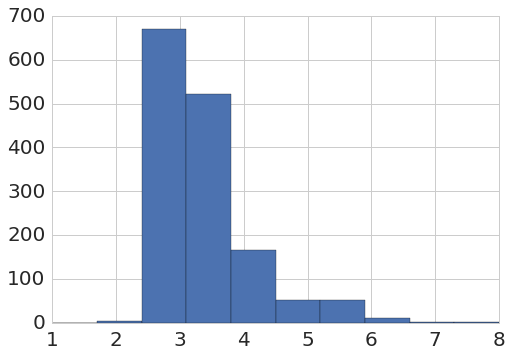

In [1099]:
interface_mutation_features_df_final = (
    interface_mutation_features_df_final.drop_duplicates(['pdb_id', 'pdb_mutation']))
interface_mutation_features_df_final['contact_distance_wt'].hist(range=(1, 8.0))

In [1100]:
print2("Number of ELASPIC PDB mutations wddg_exp:", 
       interface_mutation_features_df_final.shape[0])
print2("Number of ELASPIC PDB mutation indexes wddg_exp:",
       len(set(interface_mutation_features_df_final.index)))
print2("Number of unique ELASPIC pdb id / mutations wddg_exp:",
       interface_mutation_features_df_final[['pdb_id', 'pdb_mutation']].drop_duplicates().shape[0])

Number of ELASPIC PDB mutations wddg_exp:                   1486
Number of ELASPIC PDB mutation indexes wddg_exp:            1486
Number of unique ELASPIC pdb id / mutations wddg_exp:       1486


# Save to database

In [1101]:
_header_columns = [
    'pdb_id', 'pdb_chain', 'partner_pdb_chain', 'pdb_mutation', 'mutation', 'mutation_modeller', 'idx', 'idxs',
]

In [1102]:
interface_mutation_features_df_final[
    _header_columns + [c for c in interface_mutation_features_df_final.columns if c not in _header_columns]
].head(2)

,pdb_id,pdb_chain,partner_pdb_chain,pdb_mutation,mutation,mutation_modeller,idx,idxs,alignment_coverage,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,chain_modeller,contact_distance_mut,contact_distance_wt,ddg,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,matrix_score,model_file_mut,model_file_wt,mutation_errors,norm_dope,physchem_mut,physchem_mut_ownchain,physchem_wt,physchem_wt_ownchain,provean_score,secondary_structure_mut,secondary_structure_wt,solvent_accessibility_mut,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,ddg_exp,uniprot_id,partner_uniprot_id,uniprot_mutation,pfam_clan
34,1brs,A,D,A_R59K,R57K,R57K,0,"[0, 3]",1.0,1.0,1.0,"29.503,22.9437,-6.33637,-3.89081,-10.7025,-15....","29.4858,22.9437,-7.2822,-3.89081,-11.2318,-15....",A,2.565262,2.027869,-0.488534,273.89,283.295,557.18,2,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,,-1.453085,"0,1,0,27","0,0,0,13","0,2,0,33","0,0,0,11",-2.38,T,T,96.708630,88.793893,"39.265,-124.554,-65.6293,-238.118,-13.7351,334...","38.3782,-124.554,-65.4925,-238.757,-15.0602,33...",2.48701,P00648,P11540,R106K,None
293,1gc1,C,G,C_S42A,S42A,S339A,1,"[0, 1]",1.0,1.0,1.0,"41.9659,131.714,-6.54501,-4.0065,-7.56168,-18....","41.9676,131.714,-4.85885,-4.0074,-7.59593,-18....",C,2.930740,2.101380,-0.087220,256.83,430.720,687.56,1,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,,-0.199640,"0,0,0,20","0,0,0,14","0,0,4,20","0,0,1,14",-2.19,T,T,64.068365,61.981030,"245.555,-255.403,-135.516,-553.462,-18.2303,74...","246.905,-255.404,-136.813,-553.727,-18.2333,74...",0.00000,P01730,P04578,S67A,CL0011


In [1103]:
t = db_local.import_df(
    interface_mutation_features_df_final
    [_header_columns + [c for c in interface_mutation_features_df_final.columns if c not in _header_columns]],
    DATASET,
)

In [1104]:
t.name

'skempi'

In [1105]:
t.create_indexes([
    (['pdb_id', 'pdb_chain', 'partner_pdb_chain', 'pdb_mutation'], True)
])

In [1106]:
t.add_idx_column('_index')

1486

In [1107]:
t.compress()

File size before: 1.87 MB
File size after: 0.94 MB
File size savings: 0.94 MB (50.35 %)


# Done

In [1108]:
datetime.datetime.now()

datetime.datetime(2016, 8, 28, 23, 17, 18, 736655)